# Descargamos el dataset

Usamos la funcion streaming para no caargar los archivos de golpe

In [1]:
from datasets import load_dataset

dataset = load_dataset("librispeech_asr",
                       split="train.clean.100",
                       streaming=True,
                       trust_remote_code=True)


c:\Users\lauth\OneDrive\Desktop\hola\My_learning_project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
example = next(iter(dataset))

dataset_head = dataset.take(5)
list(dataset_head)

[{'file': '374-180298-0000.flac',
  'audio': {'path': '374-180298-0000.flac',
   'array': array([ 7.01904297e-04,  7.32421875e-04,  7.32421875e-04, ...,
          -2.74658203e-04, -1.83105469e-04, -3.05175781e-05]),
   'sampling_rate': 16000},
  'text': 'CHAPTER SIXTEEN I MIGHT HAVE TOLD YOU OF THE BEGINNING OF THIS LIAISON IN A FEW LINES BUT I WANTED YOU TO SEE EVERY STEP BY WHICH WE CAME I TO AGREE TO WHATEVER MARGUERITE WISHED',
  'speaker_id': 374,
  'chapter_id': 180298,
  'id': '374-180298-0000'},
 {'file': '374-180298-0001.flac',
  'audio': {'path': '374-180298-0001.flac',
   'array': array([-9.15527344e-05, -1.52587891e-04, -1.52587891e-04, ...,
          -2.13623047e-04, -1.83105469e-04, -2.74658203e-04]),
   'sampling_rate': 16000},
  'text': "MARGUERITE TO BE UNABLE TO LIVE APART FROM ME IT WAS THE DAY AFTER THE EVENING WHEN SHE CAME TO SEE ME THAT I SENT HER MANON LESCAUT FROM THAT TIME SEEING THAT I COULD NOT CHANGE MY MISTRESS'S LIFE I CHANGED MY OWN",
  'speaker_id': 374

In [4]:
list(dataset_head)[2]

{'file': '374-180298-0002.flac',
 'audio': {'path': '374-180298-0002.flac',
  'array': array([-2.44140625e-04, -2.44140625e-04, -1.83105469e-04, ...,
          1.83105469e-04,  3.05175781e-05, -1.52587891e-04]),
  'sampling_rate': 16000},
 'text': 'I WISHED ABOVE ALL NOT TO LEAVE MYSELF TIME TO THINK OVER THE POSITION I HAD ACCEPTED FOR IN SPITE OF MYSELF IT WAS A GREAT DISTRESS TO ME THUS MY LIFE GENERALLY SO CALM',
 'speaker_id': 374,
 'chapter_id': 180298,
 'id': '374-180298-0002'}

In [5]:
example

{'file': '374-180298-0000.flac',
 'audio': {'path': '374-180298-0000.flac',
  'array': array([ 7.01904297e-04,  7.32421875e-04,  7.32421875e-04, ...,
         -2.74658203e-04, -1.83105469e-04, -3.05175781e-05]),
  'sampling_rate': 16000},
 'text': 'CHAPTER SIXTEEN I MIGHT HAVE TOLD YOU OF THE BEGINNING OF THIS LIAISON IN A FEW LINES BUT I WANTED YOU TO SEE EVERY STEP BY WHICH WE CAME I TO AGREE TO WHATEVER MARGUERITE WISHED',
 'speaker_id': 374,
 'chapter_id': 180298,
 'id': '374-180298-0000'}

In [6]:
from IPython.display import Audio as IPythonAudio

IPythonAudio(example["audio"]["array"],
             rate=example["audio"]["sampling_rate"])

# Constuyendo la pipeline
Al igual que en la leccion pasada, el pipeline se puede cargar directamente porque el modelo es liviano (2gb aprox), de esta manera no es necesario buscar un API Inference

In [1]:
from transformers import pipeline

asr = pipeline(task="automatic-speech-recognition",
               model="distil-whisper/distil-small.en")

c:\Users\lauth\OneDrive\Desktop\hola\My_learning_project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Evaluando un poco los parametros de la pipeline y el ejemplo

In [3]:
# Podemos ver el sampling rate del modelo (Hz)
asr.feature_extractor.sampling_rate

16000

In [ ]:
# Vemos el del ejemplo
example['audio']['sampling_rate']

Como vemos que el sampling rate de la muestra es igual al del modelo, entonces no habrá problema en usarlo

# Usamos el pipeline

In [ ]:
asr(example["audio"]["array"])

In [12]:
# Resultado:

example["text"]

'CHAPTER SIXTEEN I MIGHT HAVE TOLD YOU OF THE BEGINNING OF THIS LIAISON IN A FEW LINES BUT I WANTED YOU TO SEE EVERY STEP BY WHICH WE CAME I TO AGREE TO WHATEVER MARGUERITE WISHED'

# Usando Gradio
Ahora intentare hacer algo un poco más interesante, hay una libreria "Gradio", la cual sirve para hacer intefaces muy chulas tanto para pruebas de audio con python, antes de comenzar hay que instalar gradio: %pip install gradio

In [6]:
import os
import gradio as gr

demo = gr.Blocks()

In [7]:
def transcribe_speech(filepath):
    if filepath is None:
        gr.Warning("No audio found, please retry.")
        return ""
    output = asr(filepath)
    return output["text"]

In [8]:
mic_transcribe = gr.Interface(
    fn=transcribe_speech,
    inputs=gr.Audio(sources="microphone",
                    type="filepath"),
    outputs=gr.Textbox(label="Transcription",
                       lines=3),
    allow_flagging="never")

##### Para aprender gradio, puedes ingresar a: [Building Generative AI Applications with Gradio](https://www.deeplearning.ai/short-courses/building-generative-ai-applications-with-gradio/), tambien enseñado por HuggingFace

In [9]:
file_transcribe = gr.Interface(
    fn=transcribe_speech,
    inputs=gr.Audio(sources="upload",
                    type="filepath"),
    outputs=gr.Textbox(label="Transcription",
                       lines=3),
    allow_flagging="never",
)

In [ ]:
with demo:
    gr.TabbedInterface(
        [mic_transcribe,
         file_transcribe],
        ["Transcribe Microphone",
         "Transcribe Audio File"],
    )

demo.launch(share=True, 
            server_port=8090)

In [11]:
demo.close()

Closing server running on port: 8090


# Que pasa si intentamos un audio un tanto más largo? Por ejemplo, uno de 1 min
Lo que pasara es que dependiendo del modelo, la respuesta perderá calidad
En este caso el modelo funciona muy bien con audios menores a 30 segundos, por lo que un audio de 1 min o más ocasionara que llegado al segundo 31 pueda generar palabras que no son correctas o simplemente repetir lo mismo, en pocas palabras un comportamiento no deseado.
## Entonces que hacemos con esto?
Pues para corregirlo, se puede dividir el audio en chunks, a continuacion veremos que otras propiedades nos permite usar la pipeline de este modelo y como poder solucionar este problema

In [2]:
import soundfile as sf
import io

audio, sampling_rate = sf.read('001.mp3')

In [3]:
sampling_rate

44100

In [4]:
asr.feature_extractor.sampling_rate

16000

Veremos que en primer lugar el sampling rate del modelo es 16kHz mientras que el de nuestra muestra es de 44.1kHz
Es una diferencia bastante considerable, que sucede ahora pues toca corregir esto.
# Solucionando incompatibilidad de sampling rate con librosa

In [5]:
import librosa



In [6]:
audio_16KHz = librosa.resample(audio,
                               orig_sr=sampling_rate,
                               target_sr=16000)

In [7]:
asr(audio_16KHz)

ValueError: We expect a single channel audio input for AutomaticSpeechRecognitionPipeline

Luego de 7 min y algo más de carga para la conversion de sample rate en un audio de 1 min, nos encontramos con un error, y bueno que sucede ahora? ...
pues aparece este error:
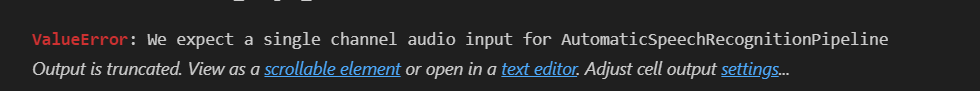
El cual significa que la entrada al modelo debe ser una entrada "single", es decir un audio mono, el audio que tenemos es "stereo" (lo cual para la percepcion humana brinda una experiencia más realista y envolvente, es decir que se escucha en la derecha e izquierda)
Entonces para las maquinas o modelos el audio stereo no es tan relevante, basta con un audio mono para poder hacer las pruebas, entonces toca convertirlo
# Convirtiendo audio stereo a mono

In [16]:
# Usando shape, vemos que el audio tiene dos salidas:

audio_16KHz.shape

(2646000, 1)

In [32]:
import numpy as np

audio_transposed = np.transpose(audio)
audio_transposed.shape

(2, 2646000)

In [33]:
import librosa

audio_mono = librosa.to_mono(audio_transposed)

In [34]:
audio_mono.shape

(2646000,)

In [35]:
from IPython.display import Audio as IPythonAudio

IPythonAudio(audio_mono,
             rate=16000)

In [21]:
res = asr(audio_mono)

c:\Users\lauth\OneDrive\Desktop\hola\My_learning_project\venv\Lib\site-packages\transformers\models\whisper\generation_whisper.py:496: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


{'text': ' Bases of people watch and see the characters are close in and in total damage fashions because the Y for scratch but until the ground hope of purchase. The Gersh are a full of square and two and the ground hope for purchase. and such laws and procedures, will never lastly run strong of nonsense or plus say to Burnan, and the other side of the country. It appears when she has a extension of her caution and her actions and her fortune in which she has been a person. There was some I am The most common is the most often, and the square is the right is The first question sentence is the zero and simple. The first question is, is the zero and the same thing, and is the zero and the same. I hope and hope the total world is a success in the zero end. and then a child says the latter says, and and and plus and to and to and to and to and to and and to and and to and and to and and best for the week to shavens she should be in best for the way to shaven and sision and poor and presen

In [ ]:
print(res["text"])

Veremos que casi al final del audio, se repiten palabras sin sentido, como: "and to and to and to"
Lo cual supone lo que inicialmente hablabamos, que el modelo solo entiende audios de 30 segundos 
Entonces toca modificar unas cosas de la pipeline:

# Modificando parametros del pipeline

In [28]:
res = asr(
    audio_mono,
    chunk_length_s=15, # 30 segundos
    batch_size=2, # Este parametro depende de la capacidad computacional que tenemos, mientras más recursos, mayor numero
    return_timestamps=True,
)["chunks"]

c:\Users\lauth\OneDrive\Desktop\hola\My_learning_project\venv\Lib\site-packages\transformers\models\whisper\generation_whisper.py:496: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


In [36]:
text = ""
for item in res:
    text += item["text"]

print(text)

 Bases of people watching the screen. The charges such as a quiz ended in total two damage foursions it goes to Y and the school has brought us back home protection. in such stores and mass offices, with their blood rush to run strong of men's inner crochet to burn a man. The issue to ban on and the abuse of war of science and and the to mention. It does him say Rassa is a bit and she I hope caution is and I hope it will watch how this commission. There was power to be a push-off, a run-off, and a space-spaction of practice, and a square case due to a whole lot to tell. The first question is, is that, is the wrong example? The first question is, is, is the same? Is he a hope and hope to die to work as you see? and the diet will works is in effect. and yes And yes, and to the judge, just the tracker should be saying, and see that. And, in general, and in children have been just probably two seasons who are and two are and she said, she said, who opened her
